In [1]:
from dataset import SFMNNDataset
from dataset_supervised import SFMNNDatasetSupervised
from dataset import SFMNNDataset
from network import SFMNNEncoder
from simulate import SFMNNSimulation
from loss import SFMNNLoss


import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
from dotenv import load_dotenv
import logging
import numpy as np

In [8]:
load_dotenv()
data_folder = os.getenv("DATA_FOLDER")

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s [%(levelname)s] %(message)s",
                    handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)

# Load the dataset
dataset = SFMNNDatasetSupervised(data_folder + 'simulation_lookuptable.json', data_folder + 'output/', patch_size=5)

# Load the dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, drop_last=False)


Loading JSON files: 100%|██████████| 105/105 [00:00<00:00, 605.23it/s]


Reading file output\simulation_sim_0_amb_0.json
Reading file output\simulation_sim_0_amb_1.json
Reading file output\simulation_sim_10_amb_0.json
Reading file output\simulation_sim_10_amb_1.json
Reading file output\simulation_sim_11_amb_0.json
Reading file output\simulation_sim_11_amb_1.json
Reading file output\simulation_sim_12_amb_0.json
Reading file output\simulation_sim_12_amb_1.json
Reading file output\simulation_sim_13_amb_0.json
Reading file output\simulation_sim_13_amb_1.json
Reading file output\simulation_sim_14_amb_0.json
Reading file output\simulation_sim_14_amb_1.json
Reading file output\simulation_sim_15_amb_0.json
Reading file output\simulation_sim_15_amb_1.json
Reading file output\simulation_sim_16_amb_0.json
Reading file output\simulation_sim_16_amb_1.json
Reading file output\simulation_sim_17_amb_0.json
Reading file output\simulation_sim_17_amb_1.json
Reading file output\simulation_sim_18_amb_0.json
Reading file output\simulation_sim_18_amb_1.json
Reading file output\si

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [61]:
# Number of spectral bands
n_spectral_bands = len(dataset.get_wl())
n_spectral_bands

241

In [77]:
x, y = dataset[0]
H, W, C = x.shape
x.shape

torch.Size([5, 5, 244])

In [78]:
# Initialize the network
encoder = SFMNNEncoder(input_channels=C, latent_dim=n_spectral_bands, num_variables=11).to(device)

optimizer = optim.Adam(encoder.parameters(), lr=0.001, weight_decay=0.0001)

In [80]:
# test the network
for i, (data, label) in enumerate(dataloader):
    data = data.to(device)
    print('input:', data.shape)
    out = encoder(data)
    print('output:', out.shape)

input: torch.Size([3, 5, 5, 244])
output: torch.Size([3, 5, 5, 11, 241])
input: torch.Size([3, 5, 5, 244])
output: torch.Size([3, 5, 5, 11, 241])


In [81]:
torch.tensor(dataset.get_wl()).shape

torch.Size([241])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# --- FourStreamSimulator ---
class FourStreamSimulator(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t1, t2, t3, t6, t7, t8, t9, t10, t11, R, F):
        
        # t1, t2, t3, t6, t7, t8, t9, t10, t11, R, F
        LTOA = t1 * t2 + (t1 * t8 * R + t9 * R + t10 * R + t11 * R + t6 * F + t7 * F) / (1 - t3 * R)
        return LTOA

# --- HyPlantSensorSimulator ---
class HyPlantSensorSimulator(nn.Module):
    def __init__(self, sensor_wavelengths):
        super().__init__()
        self.register_buffer('sensor_wavelengths', sensor_wavelengths)
        self.high_res = (sensor_wavelengths.max() - sensor_wavelengths.min()) / len(sensor_wavelengths)
        self.register_buffer('wl_range', torch.tensor([sensor_wavelengths.min(), sensor_wavelengths.max()]))

    def forward(self, L_hr, delta_lambda, delta_sigma):
        # L_hr is assumed of shape [B, H, W, spec] where spec ~241
        B, H, W, spec = L_hr.shape
        # First, bring spectral axis to channel dimension: [B, spec, H, W]
        L_hr = L_hr.permute(0, 3, 1, 2)
        
        # --- 1. Convolve high-res spectrum with Gaussian SRF ---
        # Compute effective sigma (convert FWHM to sigma using factor 2.3548)
        # (Assuming delta_sigma is broadcastable to a scalar per sample)
        sigma = (0.27 + delta_sigma) * 2.3548  # scalar or tensor broadcastable to [B, H, W] but here used as common value
        # For simplicity we assume sigma is the same for all pixels (if delta_sigma is scalar)
        sigma_val = sigma if isinstance(sigma, float) or sigma.numel() == 1 else sigma.view(-1)[0]
        
        # Determine kernel size (make it odd so that padding is symmetric)
        kernel_size = int(6 * sigma_val / self.high_res)
        if kernel_size % 2 == 0:
            kernel_size += 1
        # Create a 1D grid for the kernel (centered at 0)
        x = torch.linspace(-3 * sigma_val, 3 * sigma_val, kernel_size, device=L_hr.device)
        kernel = torch.exp(-0.5 * (x / sigma_val)**2)
        kernel = kernel / kernel.sum()
        # Convolve along the spectral (channel) dimension.
        # Reshape L_hr to [B*H*W, 1, spec] so that conv1d applies along spec axis.
        L_hr_reshaped = L_hr.permute(0, 2, 3, 1).reshape(B*H*W, 1, spec)
        L_blur = F.conv1d(L_hr_reshaped, kernel.view(1,1,kernel_size), padding=kernel_size//2)
        # Reshape back to [B, H, W, spec] then permute to [B, spec, H, W]
        L_blur = L_blur.reshape(B, H, W, spec).permute(0, 3, 1, 2)
        
        # --- 2. Integrate (sample) the blurred spectrum at sensor wavelengths ---
        # For each pixel, the effective sensor wavelengths are shifted by delta_lambda.
        # sensor_wavelengths is 1D of shape [num_sensor_channels]
        # We want effective_sensor_wl of shape [B, H, W, num_sensor_channels]:
        effective_sensor_wl = self.sensor_wavelengths.unsqueeze(0).unsqueeze(0).unsqueeze(0) + delta_lambda.unsqueeze(-1)
        
        # In the high-res domain, wavelengths run linearly from wl_range[0] to wl_range[1] 
        # with spacing self.high_res. Thus, the spectral index corresponding to a wavelength is:
        #    index = (wavelength - wl_range[0]) / high_res.
        spec_indices = (effective_sensor_wl - self.wl_range[0]) / self.high_res  # shape: [B, H, W, num_sensor_channels]
        
        # We now perform linear interpolation of L_blur along its spectral axis.
        # First, bring L_blur to shape [B, H, W, spec]:
        L_blur_perm = L_blur.permute(0, 2, 3, 1)
        # Get the indices for interpolation:
        idx_lower = spec_indices.floor().clamp(0, spec - 1)
        idx_upper = (idx_lower + 1).clamp(0, spec - 1)
        idx_lower_long = idx_lower.long()
        idx_upper_long = idx_upper.long()
        # Gather the values at the lower and upper indFices.

        L_lower = torch.gather(L_blur_perm, 3, idx_lower_long)
        L_upper = torch.gather(L_blur_perm, 3, idx_upper_long)
        # Compute the weights for interpolation.
        weight = spec_indices - idx_lower
        L_hyp = L_lower * (1 - weight) + L_upper * weight  # shape: [B, H, W, num_sensor_channels]
        
        return L_hyp


# --- SFMNNSimulation ---
class SFMNNSimulation(nn.Module):
    def __init__(self, sensor_wavelengths):
        super().__init__()
        self.four_stream = FourStreamSimulator()
        self.sensor_sim = HyPlantSensorSimulator(sensor_wavelengths)

    def forward(self, t1, t2, t3, t6, t7, t8, t9, t10, t11, R, F, delta_lambda, delta_sigma):
        # Four-stream radiance calculation
        L_hr = self.four_stream(t1, t2, t3, t6, t7, t8, t9, t10, t11, R, F)
        
        # Apply sensor simulation
        L_hyp = self.sensor_sim(L_hr, delta_lambda, delta_sigma)
        return L_hyp


In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SFMNNLoss(nn.Module):
    def __init__(self, sensor_wl, red_idx=680, nir_idx=800, 
                 gamma_f=5, gamma_N=10, gamma_a=1, tau_NDVI=0.15):
        super().__init__()
        
        # Convert to tensor and register buffers
        self.register_buffer('sensor_wl', torch.as_tensor(sensor_wl))
        self.register_buffer('w_mask', (self.sensor_wl >= 750) & (self.sensor_wl <= 770))
        
        # Find indices using PyTorch operations
        self.register_buffer('red_idx', torch.argmin(torch.abs(self.sensor_wl - red_idx)))
        self.register_buffer('nir_idx', torch.argmin(torch.abs(self.sensor_wl - nir_idx)))
        
        # Loss parameters
        self.gamma_f = gamma_f
        self.gamma_N = gamma_N
        self.gamma_a = gamma_a
        self.tau_NDVI = tau_NDVI

    def forward(self, L_hyp, L_hyp_hat, reflectance, sif):
        # Ensure mask is boolean tensor
        w_mask = self.w_mask.bool()
        
        # 1. Spectral Reconstruction Loss
        L_hyp_w = L_hyp[..., w_mask]
        L_hyp_hat_w = L_hyp_hat[..., w_mask]
        
        # Calculate MSE loss
        l_w = F.mse_loss(L_hyp_hat_w, L_hyp_w, reduction='none')

        l_w = l_w.mean(dim=(-1, -2))  # Reduce spatial and spectral dimensions
        
        # 2. NDVI Constraint
        red = reflectance[..., self.red_idx]
        nir = reflectance[..., self.nir_idx]
        ndvi = (nir - red) / (nir + red + 1e-8)
        
   
        # Vegetation mask and SIF penalty
        veg_mask = (ndvi < self.tau_NDVI).float()
        veg_mask = veg_mask.unsqueeze(-1)

        l_ndvi = (sif * veg_mask).mean(dim=(-1, -2))

        # Combine losses
        total_loss = l_w + self.gamma_N * l_ndvi
        return total_loss.mean()

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
optimizer = optim.Adam(encoder.parameters(), lr=1e-6)


sensor_wl = torch.tensor(dataset.get_wl(), dtype=torch.float, device=device)
simulation = SFMNNSimulation(sensor_wl).to(device)

NameError: name 'encoder' is not defined

In [86]:
criterion = nn.MSELoss()

In [92]:
import numpy as np

fixed_esun = 10
logger.info(f"Using fixed Esun: {fixed_esun:.4f}")

num_epochs = 10
encoder.train()

for epoch in range(num_epochs):
    epoch_losses = []

    for batch, label in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):

        optimizer.zero_grad()
    
        # batch: [B, 3623, H, W]
        batch = batch.to(device)
        label = label.to(device)

        output = encoder(batch)  

        var_indices = [0, 1, 2, 5, 6, 7, 8, 9, 10, 12, 13]
        label = label[:, :, :, var_indices, :]


        output_sup = output


        loss = criterion(label, output_sup)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.detach().cpu().numpy())
        

    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {np.mean(epoch_losses):.4f}")

2025-03-22 12:58:04,310 [INFO] Using fixed Esun: 10.0000


Epoch 1/10 - Avg Loss: 21.6834


Epoch 2/10 - Avg Loss: 27.6312


Epoch 3/10 - Avg Loss: 19.9561


Epoch 4/10 - Avg Loss: 43.0373


Epoch 5/10 - Avg Loss: 36.9899


Epoch 6/10 - Avg Loss: 19.3345


Epoch 7/10 - Avg Loss: 23.2387


Epoch 8/10 - Avg Loss: 28.9673


Epoch 9/10 - Avg Loss: 35.7267


Epoch 10/10 - Avg Loss: 20.3438


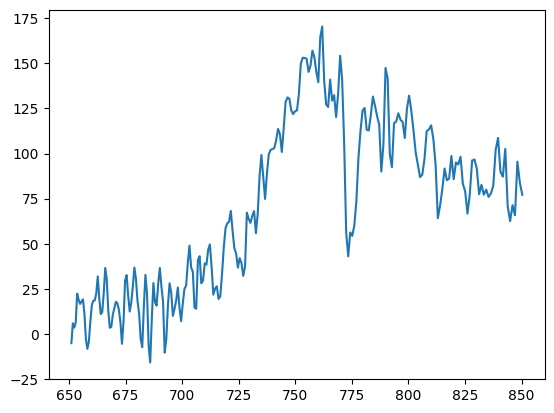

In [100]:
import matplotlib.pyplot as plt

t1      = output[:, :, :, 0, :]
t2      = output[:, :, :, 1, :]
t3      = output[:, :, :, 2, :]
t6      = output[:, :, :, 3, :]
t7      = output[:, :, :, 4, :]
t8      = output[:, :, :, 5, :]
t9      = output[:, :, :, 6, :]
t10     = output[:, :, :, 7, :]
t11     = output[:, :, :, 8, :]
R_param = output[:, :, :, 9, :]
F_param = output[:, :, :, 10, :]

L_Hat_Hyp = simulation(
    t1, t2, t3, t6, t7, t8, t9, t10, t11, R_param, F_param,
    torch.tensor(([0] * 5 * 5 * 3), device=device).view(3, 5, 5), torch.tensor(0.01, device=device)
)

x = sensor_wl.detach().cpu().numpy()
y = L_Hat_Hyp[0][0][0].detach().cpu().numpy()

plt.plot(x, y)


In [11]:
dataset = SFMNNDataset(data_folder + 'simulation_lookuptable.json', data_folder + 'output/', patch_size=5)
H, W, C = dataset[0].shape # [5, 5, 245]

# Load the dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, drop_last=False)

Loading JSON files: 100%|██████████| 105/105 [00:00<00:00, 606.31it/s]


Reading file output\simulation_sim_0_amb_0.json
Reading file output\simulation_sim_0_amb_1.json
Reading file output\simulation_sim_10_amb_0.json
Reading file output\simulation_sim_10_amb_1.json
Reading file output\simulation_sim_11_amb_0.json
Reading file output\simulation_sim_11_amb_1.json
Reading file output\simulation_sim_12_amb_0.json
Reading file output\simulation_sim_12_amb_1.json
Reading file output\simulation_sim_13_amb_0.json
Reading file output\simulation_sim_13_amb_1.json
Reading file output\simulation_sim_14_amb_0.json
Reading file output\simulation_sim_14_amb_1.json
Reading file output\simulation_sim_15_amb_0.json
Reading file output\simulation_sim_15_amb_1.json
Reading file output\simulation_sim_16_amb_0.json
Reading file output\simulation_sim_16_amb_1.json
Reading file output\simulation_sim_17_amb_0.json
Reading file output\simulation_sim_17_amb_1.json
Reading file output\simulation_sim_18_amb_0.json
Reading file output\simulation_sim_18_amb_1.json
Reading file output\si

In [12]:
sensor_wl = torch.tensor(dataset.get_wl(), device=device)
n_spectral_bands = sensor_wl.shape[0]


encoder = SFMNNEncoder(input_channels=C-1, latent_dim=n_spectral_bands, num_variables=12).to(device)
simulation = SFMNNSimulation(sensor_wl).to(device)
criterion = SFMNNLoss(sensor_wl).to(device)

In [14]:
import torch.nn as nn

In [15]:
optimizer = optim.Adam(encoder.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [17]:
import numpy as np

fixed_esun = 10
logger.info(f"Using fixed Esun: {fixed_esun:.4f}")

num_epochs = 50
encoder.train()

for epoch in range(num_epochs):
    epoch_losses = []

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):

        optimizer.zero_grad()

        # MEASUREMENT
        batch = batch.to(device)

        # ENCODER
        output = encoder(batch[:, :, :, :-1])  # Removes FWHM before computing the data

        t1      = output[:, :, :, 0, :]
        t2      = output[:, :, :, 1, :]
        t3      = output[:, :, :, 2, :]
        t6      = output[:, :, :, 3, :]
        t7      = output[:, :, :, 4, :]
        t8      = output[:, :, :, 5, :]
        t9      = output[:, :, :, 6, :]
        t10     = output[:, :, :, 7, :]
        t11     = output[:, :, :, 8, :]
        R_param = output[:, :, :, 9, :]
        F_param = output[:, :, :, 10, :]
        d_lamb  = output[:, :, :, 11, :].mean(dim=-1)

        # SIMULATION

        FWHM = batch[:, :, :, -1]
        
        LTOA = t1 * t2 + (t1 * t8 * R_param + t9 * R_param + t10 * R_param + t11 * R_param + t6 * F_param + t7 * F_param) / (1 - t3 * R_param)

        """
        L_Hat_Hyp = simulation(
            t1, t2, t3, t6, t7, t8, t9, t10, t11, R_param, F_param,
            d_lamb, FWHM
        )
        """

        
        # LOSS
        """
        L_Hyp = batch[:, :, :, :241]
        loss = criterion(L_Hyp, L_Hat_Hyp, R_param, F_param)
        """
        loss = criterion(batch[:, :, : , :241], LTOA)

        
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.detach().cpu().numpy())
        

    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {np.mean(epoch_losses):.4f}")



2025-03-22 15:34:11,660 [INFO] Using fixed Esun: 10.0000


Epoch 1/50 - Avg Loss: 226590277632.0000


Epoch 2/50 - Avg Loss: 225778794496.0000


Epoch 3/50 - Avg Loss: 226141880320.0000


Epoch 4/50 - Avg Loss: 443276099584.0000


Epoch 5/50 - Avg Loss: 442176634880.0000


Epoch 6/50 - Avg Loss: 441336594432.0000


Epoch 7/50 - Avg Loss: 226926444544.0000


Epoch 8/50 - Avg Loss: 441292947456.0000


Epoch 9/50 - Avg Loss: 442611269632.0000


Epoch 10/50 - Avg Loss: 229390237696.0000


Epoch 11/50 - Avg Loss: 442718322688.0000


Epoch 12/50 - Avg Loss: 225861664768.0000


Epoch 13/50 - Avg Loss: 443214135296.0000


Epoch 14/50 - Avg Loss: 226767781888.0000


Epoch 15/50 - Avg Loss: 224501301248.0000


Epoch 16/50 - Avg Loss: 233251733504.0000


Epoch 17/50 - Avg Loss: 226679816192.0000


Epoch 18/50 - Avg Loss: 225880866816.0000


Epoch 19/50 - Avg Loss: 443374469120.0000


Epoch 20/50 - Avg Loss: 442768916480.0000


Epoch 21/50 - Avg Loss: 444390408192.0000


Epoch 22/50 - Avg Loss: 440349065216.0000


Epoch 23/50 - Avg Loss: 226245967872.0000


Epoch 24/50 - Avg Loss: 226394161152.0000


Epoch 25/50 - Avg Loss: 576901939200.0000


Epoch 26/50 - Avg Loss: 441474318336.0000


Epoch 27/50 - Avg Loss: 443500101632.0000


Epoch 28/50 - Avg Loss: 226708586496.0000


Epoch 29/50 - Avg Loss: 443684388864.0000


Epoch 30/50 - Avg Loss: 225677164544.0000


Epoch 31/50 - Avg Loss: 440981848064.0000


Epoch 32/50 - Avg Loss: 442074660864.0000


Epoch 33/50 - Avg Loss: 224954368000.0000


Epoch 34/50 - Avg Loss: 226416852992.0000


Epoch 35/50 - Avg Loss: 226609004544.0000


Epoch 36/50 - Avg Loss: 443553480704.0000


Epoch 37/50 - Avg Loss: 443349958656.0000


Epoch 38/50 - Avg Loss: 442248527872.0000


Epoch 39/50 - Avg Loss: 226958393344.0000


Epoch 40/50 - Avg Loss: 442414268416.0000


Epoch 41/50 - Avg Loss: 227176710144.0000


Epoch 42/50 - Avg Loss: 441747701760.0000


Epoch 43/50 - Avg Loss: 444767076352.0000


Epoch 44/50 - Avg Loss: 225204125696.0000


Epoch 45/50 - Avg Loss: 225785724928.0000


Epoch 46/50 - Avg Loss: 227602972672.0000


Epoch 47/50 - Avg Loss: 226253799424.0000


Epoch 48/50 - Avg Loss: 226516221952.0000


Epoch 49/50 - Avg Loss: 225599488000.0000


Epoch 50/50 - Avg Loss: 226026340352.0000


In [23]:
FWHM = batch[:, :, :, -1]

In [27]:
FWHM / 2.355

tensor([[[4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463]],

        [[4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463]],

        [[4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463],
         [4.2463, 4.2463, 4.2463, 4.2463, 4.2463]]])

In [36]:
d_lamb = torch.tensor([0.0] * 5 * 5 * 3).view(3, 5, 5).to(device)

In [37]:
t1      = output_sup[:, :, :, 0, :]
t2      = output_sup[:, :, :, 1, :]
t3      = output_sup[:, :, :, 2, :]
t6      = output_sup[:, :, :, 3, :]
t7      = output_sup[:, :, :, 4, :]
t8      = output_sup[:, :, :, 5, :]
t9      = output_sup[:, :, :, 6, :]
t10     = output_sup[:, :, :, 7, :]
t11     = output_sup[:, :, :, 8, :]
R_param = output_sup[:, :, :, 9, :]
F_param = output_sup[:, :, :, 10, :]


# t1, t2, t3, t4, t5, t6, R, F, delta_lambda, delta_sigma, E_s, cos_theta_s
# Use a realistic delta_sigma (set to 0.0 here to preserve spectral resolution).
sim_output_full = simulation(
    t1, t2, t3, t6, t7, t8, t9, t10, t11, R_param, F_param,
    d_lamb, torch.tensor(0.1 / 2.355)
)

L_hr shape: torch.Size([3, 5, 5, 241])
torch.Size([3, 5, 5, 241])
torch.Size([3, 5, 5, 241])


In [40]:
import matplotlib.pyplot as plt

obs = sim_output_full[0][0][0].detach().cpu().numpy()

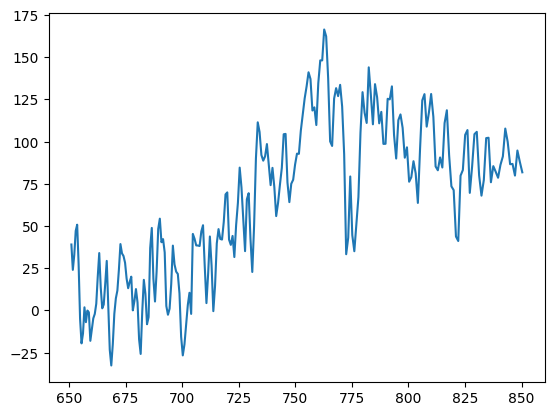

In [42]:
plt.plot(sensor_wl.detach().cpu().numpy(), obs)
plt.show()


In [43]:
(sensor_wl.max() - sensor_wl.min()) / len(sensor_wl)

tensor(0.8270, device='cuda:0')

In [44]:
d_lamb = torch.tensor([0.0] * 5 * 5 * 3).view(3, 5, 5).to(device)

In [45]:
d_lamb.shape

torch.Size([3, 5, 5])

In [46]:
FWHM = 10
sigma = FWHM / 2.355

In [47]:
sim_output_full = simulation(
    t1, t2, t3, t6, t7, t8, t9, t10, t11, R_param, F_param,
    d_lamb, torch.tensor(0.1 / 2.355)
)

L_hr shape: torch.Size([3, 5, 5, 241])
torch.Size([3, 5, 5, 241])
torch.Size([3, 5, 5, 241])


In [48]:
predicted = sim_output_full[0][0][0].detach().cpu().numpy()

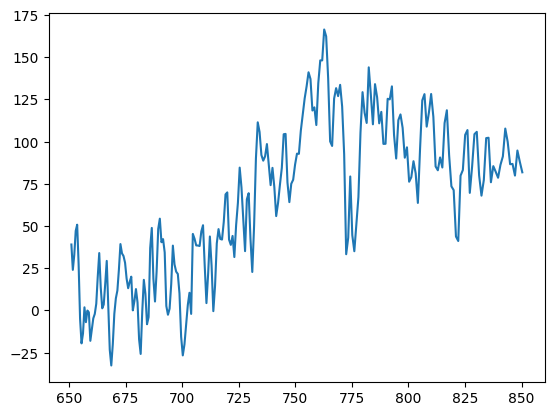

In [49]:
plt.plot(sensor_wl.detach().cpu().numpy(), obs)
plt.show()


In [50]:
real = batch[0][0][0][:241].detach().cpu().numpy()

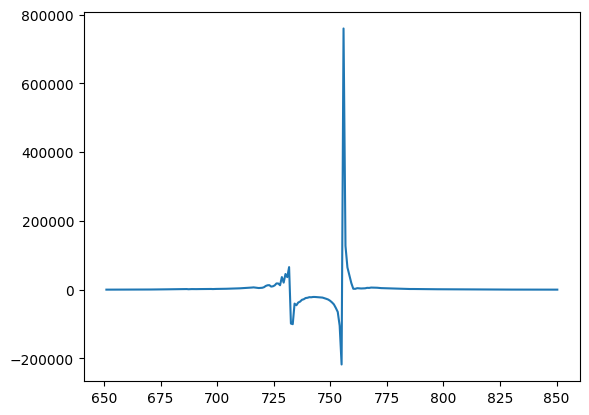

In [51]:
plt.plot(sensor_wl.detach().cpu().numpy(), real)
plt.show()
